In [1]:
import pandas as pd
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
import pyro.ops.stats as stats

import rethinking

"The posterior distribution is a probability distribution.
And like all probability distributions, we can imagine drawing _samples_ from it. The sampled
events in this case are parameter values. Most parameters have no exact empirical realiza-
tion. The Bayesian formalism treats parameter distributions as relative plausibility, not as
any physical random process. In any event, randomness is always a property of informa-
tion, never of the real world. But inside the computer, parameters are just as empirical as
the outcome of a coin flip or a die toss or an agricultural experiment. The posterior defines
the expected frequency that different parameter values will appear, once we start plucking
parameters out of it."

"It is often easier and more intuitive to work with samples from the posterior, than to work with probabilities and integrals directly".

# 3.1

In [2]:
# Compute the posterior for globe tossing moddel with grid approximation
p_grid = torch.linspace(start=0,end=1,steps=1000)
prior = torch.tensor(1.).repeat(1000)
likelihood = dist.Binomial(total_count=9, probs=p_grid).log_prob(torch.tensor(6.)).exp()
posterior = likelihood * prior
posterior = posterior / sum(posterior)

In [17]:
posterior

tensor([2.4130e-42, 8.4336e-19, 5.3813e-17, 6.1112e-16, 3.4234e-15, 1.3020e-14,
        3.8760e-14, 9.7442e-14, 2.1646e-13, 4.3751e-13, 8.2075e-13, 1.4496e-12,
        2.4359e-12, 3.9257e-12, 6.1052e-12, 9.2078e-12, 1.3521e-11, 1.9393e-11,
        2.7244e-11, 3.7569e-11, 5.0951e-11, 6.8070e-11, 8.9711e-11, 1.1677e-10,
        1.5028e-10, 1.9140e-10, 2.4144e-10, 3.0186e-10, 3.7431e-10, 4.6060e-10,
        5.6276e-10, 6.8300e-10, 8.2377e-10, 9.8773e-10, 1.1778e-09, 1.3972e-09,
        1.6494e-09, 1.9380e-09, 2.2672e-09, 2.6414e-09, 3.0651e-09, 3.5434e-09,
        4.0818e-09, 4.6861e-09, 5.3623e-09, 6.1171e-09, 6.9575e-09, 7.8908e-09,
        8.9251e-09, 1.0069e-08, 1.1330e-08, 1.2720e-08, 1.4246e-08, 1.5920e-08,
        1.7753e-08, 1.9757e-08, 2.1943e-08, 2.4324e-08, 2.6913e-08, 2.9725e-08,
        3.2774e-08, 3.6075e-08, 3.9645e-08, 4.3501e-08, 4.7658e-08, 5.2137e-08,
        5.6955e-08, 6.2133e-08, 6.7690e-08, 7.3649e-08, 8.0031e-08, 8.6860e-08,
        9.4158e-08, 1.0195e-07, 1.1027e-

To draw 10000 samples from this posterior, we imagine the posterior as a bucket full of parameter values. Within it, each value exists in proportion to its posterior prob., such that values closer to the peak are more common than those in tails.

We draw 10000 values, and assuming it is well-mixed, the samples should have the same proportion as the exact posterior density.

In [18]:
samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([int(1e4)]))

In [19]:
samples

tensor([0.8719, 0.7227, 0.6296,  ..., 0.5485, 0.7257, 0.5175])

_Samples_ has randomly taken values from *p_grid* and the probability of each value is given by *posterior*.

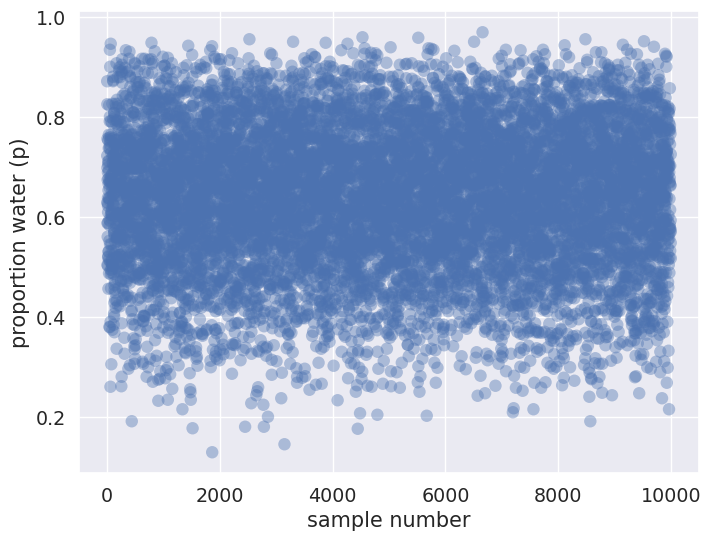

In [21]:
ax = sns.scatterplot(x=range(len(samples)), y=samples, s=80, alpha=0.4, edgecolor="none")
ax.set(xlabel="sample number", ylabel="proportion water (p)");

/tmp/ipykernel_19782/3994540878.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(samples)


[Text(0.5, 0, 'proportion water (p)'), Text(0, 0.5, 'density')]

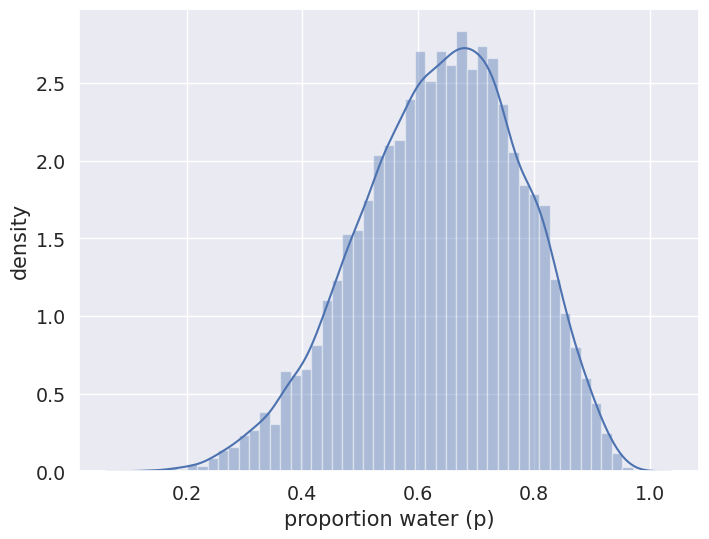

In [22]:
ax = sns.distplot(samples)
ax.set(xlabel='proportion water (p)', ylabel='density')

This estimated density is similar to the (ideal) posterior computed via grid approximation. Quickly checking an even higher number of samples and whether this makes the DE more similar to the ideal one.

/tmp/ipykernel_19782/1406157724.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(samples)


[Text(0.5, 0, 'proportion water (p)'), Text(0, 0.5, 'density')]

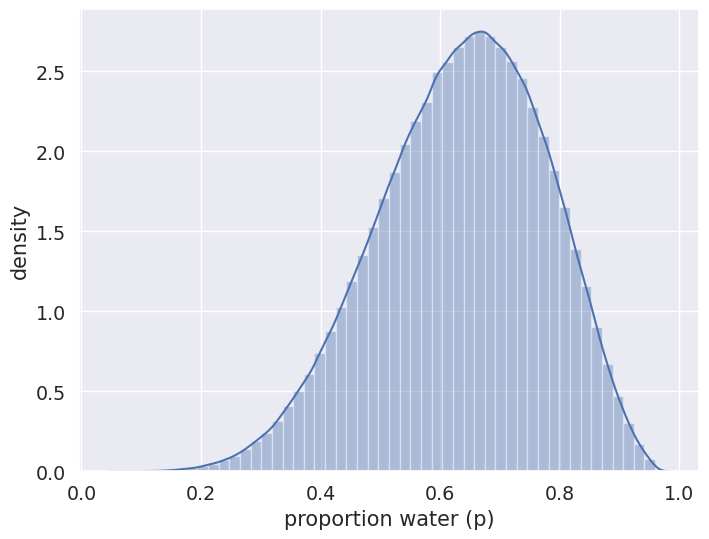

In [25]:
# Compute the posterior for globe tossing moddel with grid approximation
p_grid = torch.linspace(start=0,end=1,steps=int(1e6))
prior = torch.tensor(1.).repeat(int(1e6))
likelihood = dist.Binomial(total_count=9, probs=p_grid).log_prob(torch.tensor(6.)).exp()
posterior = likelihood * prior
posterior = posterior / sum(posterior)
samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([int(1e6)]))
ax = sns.distplot(samples)
ax.set(xlabel='proportion water (p)', ylabel='density')

# 3.2

**Intervals of defined boundaries**

In [26]:
# add up posterior probability where p < 0.5
(posterior[p_grid < 0.5]).sum()

tensor(0.1719)

Get the same defined boundary, whilst using samples from the posterior. Here we similarly add up all of the samples below 0.5, but also divide that count by the total number of samples (i.e. the frequency)

In [27]:
(samples < 0.5).sum().float() / 1e6

tensor(0.1725)

In [28]:
# how much posterior probability lies between 0.5 and 0.75
((samples > 0.5) & (samples < 0.75)).sum().float() / 1e6

tensor(0.6042)

**Intervals of defined mass**

In [31]:
# where is the lower 80% posterior probability boundary (at which p=x (proportion water))
stats.quantile(samples, 0.8)

tensor(0.7602)

In [32]:
# where is the posterior probability boundary lower 10% and upper 90%
stats.quantile(samples, [0.1, 0.9])

tensor([0.4479, 0.8118])

Consider the posterior distribution and different intervals (Figure 3.3, Statistical Rethinking). THe posterior is consistent with observing three waters in three tosses and a uniform (flat) prior. It is highly skewed with its maximum value at the boundary of *p = 1*. To compute it through grid approximation:

In [33]:
p_grid = torch.linspace(start=0, end=1, steps=1000)
prior = torch.tensor(1.).repeat(1000)
likelihood = dist.Binomial(total_count=3,
                           probs=p_grid).log_prob(torch.tensor(3.)).exp()
posterior = likelihood * prior
posterior = posterior / posterior.sum()
samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([int(1e4)]))

In [36]:
# 50% percentile confidence interval
stats.pi(samples, prob = 0.5)

tensor([0.7077, 0.9309])

This interval assigns equal mass (25%) to both the left and right tail of the interval. However, it does exclude the most probable parameter values near *p=1*. This can thus be misleading because it does not describe the shape of the posterior distribution.

In [38]:
# 50% highest posterior density interval
stats.hpdi(samples, prob=0.5)

tensor([0.8398, 1.0000])

The HDPI is the narrowest interval containing the specific 50% probability mass. Although an infinite number of posterior intervals with the same mass should be possible, the HPDI gets you an interval that best represents the parameter values consistent with the data (i.e. the most dense).

attachment:image.png
<img src=attachment:image.png width="500"/>

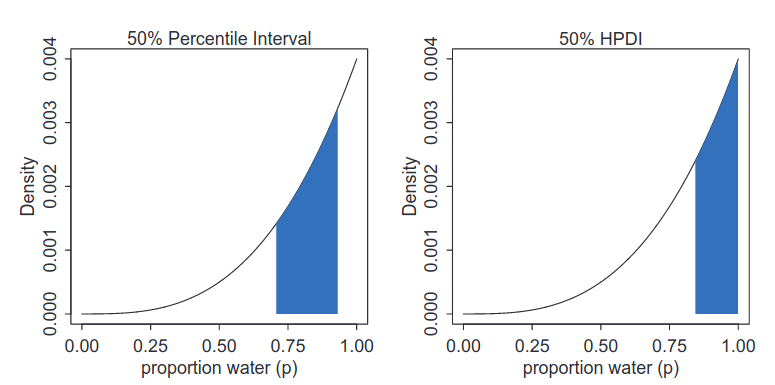

PI and HPDI as different here because the posterior is highly skewed, but in a better balanced distribution, the two types of intervals are very similar (e.g. a Gaussian).

**Point estimates**

In [39]:
# maximum a posteriori (MAP) estimate
p_grid[posterior.argmax()]

tensor(1.)

In [40]:
# MAP for samples from the posterior
adj = 0.01
silverman_factor = (0.75 * samples.size(0)) ** (-0.2)
bandwidth = adj * silverman_factor * samples.std()
x = torch.linspace(samples.min(), samples.max(), 1000)
y = dist.Normal(samples, bandwidth).log_prob(x.unsqueeze(-1)).logsumexp(-1).exp()
x[y.argmax()]

tensor(0.9991)

In [41]:
print(samples.mean())
print(samples.median())

tensor(0.7999)
tensor(0.8398)


**Loss function**

"It turns out that the parameter value that maximizes expected
winnings (minimizes expected loss) is the median of the posterior distribution"

"Calculating expected loss for any given decision means using the posterior to average
over our uncertainty in the true value. Of course we don’t know the true value, in most cases.
But if we are going to use our model’s information about the parameter, that means using the
entire posterior distribution. So suppose we decide *p = 0.5* will be our decision. Then the
expected loss will be:"

In [42]:
(posterior * (0.5 - p_grid).abs()).sum()

tensor(0.3129)

The symbols *posterior* and *p_grid* are the same ones we’ve been using throughout this
chapter, containing the posterior probabilities and the parameter values, respectively. All
the code above does is compute the weighted average loss, where each loss is weighted by its
corresponding posterior probability. There’s a trick for repeating this calculation for every
possible decision

In [44]:
loss = (posterior * (p_grid.unsqueeze(1) - p_grid).abs()).sum(1)
p_grid[loss.argmin()]

tensor(0.8408)

And this is actually the posterior median, the parameter value that splits the posterior density
such that half of the mass is above it and half below it.

# 3.3